# 이미지 표출에 관하여

In [4]:
import numpy as np
import os
parent_label_path = os.getenv("HOME") + "/workspace/Hackerton//building/validation/label"
parent_raw_path = os.getenv("HOME") + "/workspace/Hackerton//building/validation/raw"

print(parent_label_path)
label_json_file = parent_label_path + "/" + "BLD00007_PS3_K3A_NIA0276.json"
raw_png_file = parent_raw_path + "/" + "BLD00007_PS3_K3A_NIA0276.png"
raw_kml_file = parent_raw_path + "/" + "BLD00007_PS3_K3A_NIA0276.kml"



/home/aiffel-dj15/sia_data/building/validation/label


In [5]:
from pykml import parser

with open(raw_kml_file) as f:
    doc = parser.parse(f)
# 일단 파싱하는건 이 후로 하고 coordinate를 얻었다 치고 다음 단계로 건너뛸 것

In [13]:
coord = [[31.4289436358,30.0362447983,0],[31.4347830009,30.0363144197,0],[31.4347031225,30.0413951468,0],[31.4288634597,30.0413255113,0]]
# 이미지는 1024 x 1024 pixel 이다

In [10]:
example = "242.7934760512283,117.09330873039453,239.79108351967977,154.52313562370014,289.23048053917967,156.925049648939,291.0319160581088,122.6977747892852,248.99842061642872,114.49123520305244"
ex_im_coord = example.split(",")
ex_im_coord = [float(x)/1024 for x in ex_im_coord]
print(ex_im_coord[:5])

[0.23710300395627765, 0.1143489343070259, 0.23417097999968728, 0.15090149963251967, 0.28245164115154264]


In [5]:
def convert_to_real_coord(maxPixel, im_coords, im_position_real_world, is_polygon=True) :
    '''
    maxPixel : 사진 width 혹은 height pixel. 이번 과업에서는 사진이 정사각형이라서 먹힌다. 
    im_coords : 사진 내의 픽셀 좌표로 표현된 좌표들
    im_position_real_world : 사진이 실제로 위치하는 현실 좌표 
    is_polygon : polygon이 닫혀있는지 확인하고, 닫혀있는 좌표가 아니라면 닫힌 형태로 만들지 그대로 둘 지 결정.
    
    '''
    
    im_coord_ratio = [float(x)/1024 for x in im_coords]
    min_x,max_x,min_y,max_y=180,0,180,0
    for i in im_position_real_world :
        min_x = min(min_x, i[0])
        min_y = min(min_y, i[1])
        max_x = max(max_x, i[0])
        max_y = max(max_y, i[1])

    width = max_x - min_x
    height = max_y - min_y

    real_coord = []
    for i in range(0,len(im_coord_ratio),2) :
        temp_coord = []
        temp_coord.append(min_x + width * im_coord_ratio[i])
        temp_coord.append(min_y + height * im_coord_ratio[i+1])
        real_coord.append(temp_coord)
    if is_polygon :
        if real_coord[0] != real_coord[-1] :
            real_coord.append(real_coord[-1])
    return real_coord

In [15]:
# 비율로 변환한 좌표들을 단순하게 실좌표로 바꿔보자 
min_x,max_x,min_y,max_y=180,0,180,0

for i in coord :
    min_x = min(min_x, i[0])
    min_y = min(min_y, i[1])
    max_x = max(max_x, i[0])
    max_y = max(max_y, i[1])

width = max_x - min_x
height = max_y - min_y

real_coord = []
for i in range(0,len(ex_im_coord),2) :
    temp_coord = []
    temp_coord.append(min_x + width * ex_im_coord[i])
    temp_coord.append(min_y + height * ex_im_coord[i+1])
    real_coord.append(temp_coord)
print(real_coord)

[[31.430267000700564, 30.036833735162286], [31.430249644463952, 30.03702199361228], [31.430535443826805, 30.037034074368428], [31.43054585756877, 30.0368619235933], [31.430302870256224, 30.036820647676457]]


In [16]:
# 닫힌 모양이 되어야 한다. 
real_coord.append(real_coord[-1])

In [17]:
import cv2
#img = np.zeros((1024, 1024, 3), dtype = "uint8")
ex_im_coord_num = [float(x) for x in ex_im_coord]

In [36]:
# maximum = 1024
# bilinear interpolation을 직접 구현했지만...아무래도 같은 평면좌표에서 interpolation하는 것이기 때문에
# 이 함수는 다른 평면좌표로 데이터가 옮겨질 경우에 유용할듯 하다. 
def bilinear_interpolation(origin_x, origin_y, max_value) : 

    dx = origin_x - int(origin_x)
    dy = origin_y - int(origin_y)

    tl_weight = (1.0-dx) *(1.0-dy)
    tr_weight = dx * (1.0-dy)
    bl_weight = (1.0 - dx) * dy
    br_weight = dx * dy

    tl = [int(origin_x), int(origin_y)]
    tr = [tl[0]+1, tl[1]]
    bl = [tl[0], tl[1]+1]
    br = [tl[0]+1 , tl[1]+1]


    weights = [(tl_weight,0), (tr_weight,1), (bl_weight,2), (br_weight,3)]

    weights.sort(key=lambda x : x[0], reverse=True)
    
    maximum = weights[0][1]
    result = []
    
    #print(tl, tr, bl, br)
    #print(weights)
    
    if maximum == 0 :
        result = tl
    elif maximum == 1 :
        result = tr
    elif maximum == 2 :
        result = bl
    else :
        result = br
    
    if result[0] >= max_value :
        result[0] = max_value-1
    if result[1] >= max_value :
        result[1] = max_value-1
        
    return result
print(bilinear_interpolation(1.44123,2.533268))

[1, 3]


# rasterio 사용하기

## rasterio 설치 
1. ubuntu 기준
conda-forge 채널 추가하라고 나와있지만 이렇게 설치해도 설치는 가능하다.(1.2.3ver)
```
conda install rasterio
```
2. 왜 rasterio 인가?
- 공신력있다. GIS 오픈소스로 유명한 회사(MapBox)에서 개발한다. 
- 편하다. GDAL을 써서 numpy로 이미지 데이터를 읽고 똑같은 결과를 리턴하려면 여러 줄에 걸쳐서 처리해야 하는 것을 rasterio는 한번에 가능하게 해준다. 
- GDAL + OpenCV를 섞은 편리함이 있다. GDAL에서 제공하는 GIS 관련 데이터를 읽어낼 수 있으면서, 이미지 출력에서 OpenCV에서 제공하는 기능들을 제공한다. GDAL은 C++스타일로 속성값들의 이름이 낯설고 이해하기 어렵지만 rasterio는 python의 장점을 잘 살린 라이브러리로 보인다. 
3. 주의사항 
- 윈도우에서 설치하려면 gdal과 rasterio 버전을 python 버전과 core 타입에 맞춰서 파일을 다운로드 받은 후 설치를 해야 하는 매우 독특한 방법을 고수하기 때문에(심지어 공식 홈페이지는 구버전을 안내해준다.) 불편하다. 

In [4]:
import rasterio
from rasterio.plot import show
import os

In [28]:
spacenet_sample = os.getenv('HOME') + "/spacenet_paris/AOI_3_Paris_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_3_Paris_img3.tif"
src = rasterio.open(spacenet_sample)
#print(image)

In [13]:
# 각 채널에서 이미지 값의 min, max값을 찍어본다. 
for i in image : 
    print(i.min(),i.max())

0 203
0 328
0 405
0 259
0 371
0 334
0 869
0 442


0 2


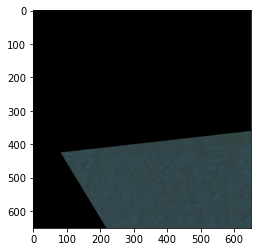

1 3


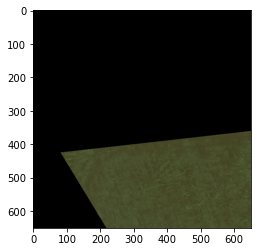

2 4


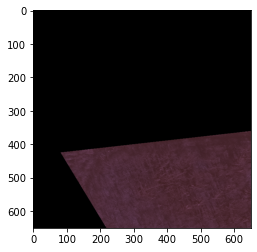

3 5


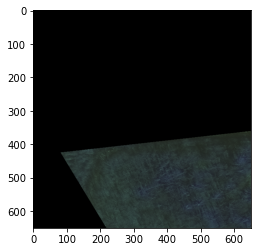

4 6


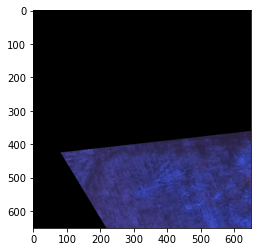

In [16]:
# 채널 값 normalization : 0-1 사이로.
# 학습 시 이미지 데이터는 0-1 사이로 정규화해서 모델에 입력한다. 
image_norm = (image - image.min()) / (image.max() - image.min())
for i in range(0, 5) :
    print(i, i+2)
    show(image_norm[i:i+3])

In [21]:
import numpy as np
im_extract = np.zeros(shape=(3,650,650))

In [25]:
# BGR를 RGB로 순서를 바꿔서 넣는다.
im_extract[2] = image_norm[1]
im_extract[1] = image_norm[2]
im_extract[0] = image_norm[4]

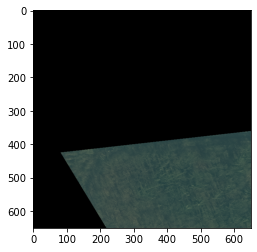

<AxesSubplot:>

In [27]:
show(im_extract)

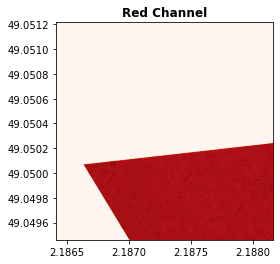

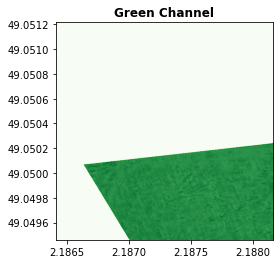

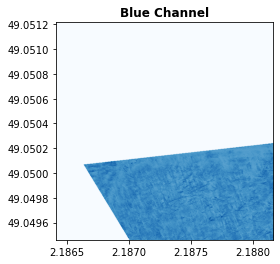

<AxesSubplot:title={'center':'Blue Channel'}>

In [9]:
# 번외 : show에는 cmap을 설정해서 출력할 수 있는 기능이 있다. 보여주려고 예시를 든 것일 뿐, 
# 실제로 1번 채널은 costal blue, 2번 채널은 blue, 3번 채널은 green이다. 
# 채널 번호는 1번부터 시작한다. 
show((src, 1), cmap='Reds', title='Red Channel')
show((src, 2), cmap='Greens', title='Green Channel')
show((src, 3), cmap='Blues', title='Blue Channel')

## geotiff의 8채널에 관하여
1. RGB 채널이 포함되어 있는가?
`The 8-band, multispectral images include the following bands: Coastal Blue, Blue, Green, Yellow, Red, Red Edge, Near Infrared 1 (NIR1), and Near Infrared 2 (NIR2).` => BGR을 뽑으려면 2, 3, 5 채널을 써야 한다. 
- Coastal Blue : 좀 더 파란 색을 가진 파장을 검출해낸 결과. 
- Yellow : Green과 Red 사이에 걸쳐져 있는 파장
- Red-Edge : 좀 더 빨간 색을 가진 파장을 검출해낸 결과
2. 각 채널에 대해 알아야 하는 이유가 무엇인가? 
이미지 

# Reference

1. https://docs.astraea.earth/hc/en-us/articles/360050182351-Visualizing-an-RGB-Image-using-Rasterio
2. https://rasterio.readthedocs.io/en/latest/topics/plotting.html    